In [1]:
from sqlalchemy import select
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.coordinates import Angle, ICRS, GeocentricTrueEcliptic, HeliocentricTrueEcliptic
from astropy.time import Time
import astropy.units as u

from models import session, TanWcs, RectangularCoords, RectangularHeliocentricCoords, rect2sphere

%matplotlib inline

# Region search

The goal of the notebook is to demonstrate the minimum requirements for a region search module for KBMOD and related issues with trying to perform region search on spherical systems. 

A fake database is created, `example.sqlite3`, that contains the minimum required data to record a partially-complete WCS. The WCS is only a partial one, because it represents a simple `TAN` projection for an `(1000, 1000)` image without specifying the coordinate system and scale. They all have the same reference pixel and the linear distortion coefficients to the sky coordinates, which is a realistic scenario for an space observatory with excellent instrumentation over reasonably-short time periods.

Each WCS, however, will have a different value of the reference pixel's sky coordinates. These are assigned randomly and do not represent any particular cadence, which is not a very realistic scenario.

The WCS is also used to calculate the on-sky coordinates of the `[0,0]`th pixel. This is not immediately important for us, but is important when trying to calculate overlap.These, `refpix` and `corner`, coordinates are then converted to cartesian (rectangular) representation.         
See `create_db.py` for details. 

The database contains 30 000 faked WCS's demonstrating that search performance is really not an issue, even when indexing is not present.          

There are two important tables for this bit - `TanWCS` representing our on-sky pointings and the `GeometricCoords` representing the Cartesian representation of whatever spherical coordinate system the WCS is expressed in.       
See `models.py` for database schema.  

First, let's visualize all our fake pointings and showcase how both approaches can seemingly work ok.

In [28]:
# all faked pointings
all_pointings = TanWcs.all()

# pointings selected in a square around their sky coordinates
sky_pointings = TanWcs.query_square_naive(160, 0, 25)

# pointings selected in (approximately) the same square around their cartesian coordinates
cart_pointing = RectangularCoords.query_square(160, 0, 25)

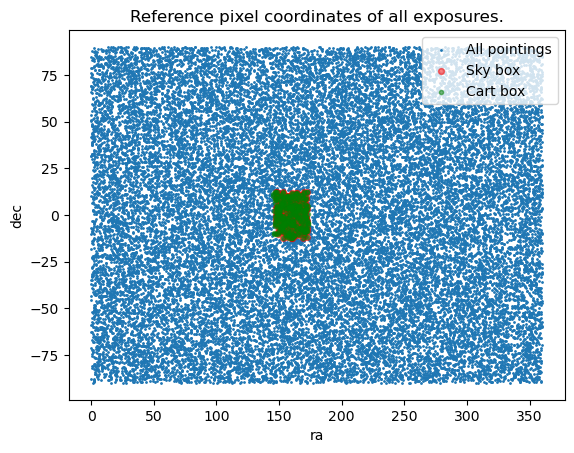

In [29]:
plt.scatter(all_pointings[:, 0], all_pointings[:, 1], s=1, label="All pointings")
plt.scatter(sky_pointings[:, 0], sky_pointings[:, 1], s=18, color="red", alpha=0.5, label="Sky box")
plt.scatter(cart_pointing[:, 0], cart_pointing[:, 1], s=9, color="green", alpha=0.5, label="Cart box")

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("Reference pixel coordinates of all exposures.")
plt.legend()

On the plot we the blue dots are all faked pointings. The created pointings span the whole sky.       
The green and red dots in the middle are pointings selected in a 25 degree region around `(160, 0)` degrees. The red dots were selected from the table of all pointings, by drawing a simple box around the sky coordinates. The range of this box is approximately `148-->172 deg ra` and `-12-->12 deg dec`. The green dots were selected by converting the pointing `(ra, dec)` to cartesian `(x, y, z)` before selecting, approximately, the same rectangle. The red dots are plotted with a slightly larger radii than the green or blue ones, so as to avoid being obscured by the overplotted green dots.

So all is well, everything seems to match - wonderful. Unless we select an area closer to the corners of the projection.

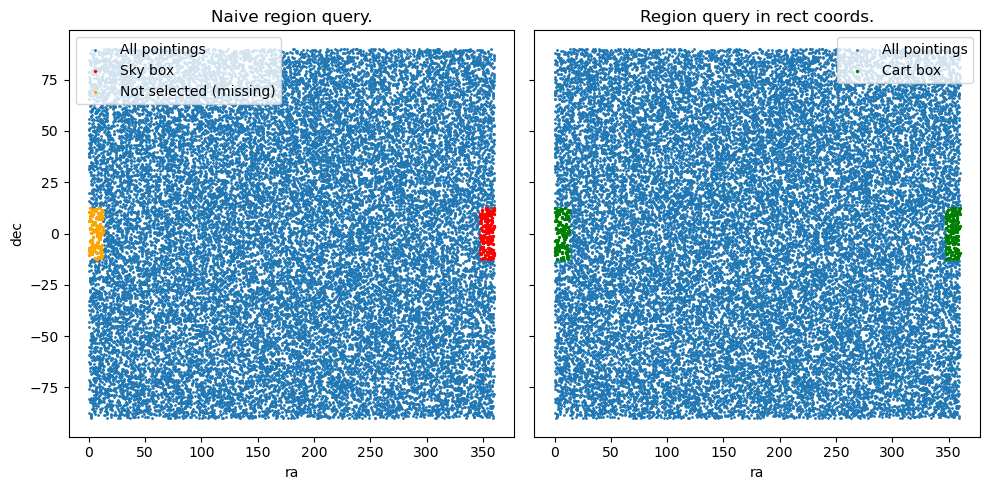

In [4]:
sky_pointings = TanWcs.query_square_naive(360, 0, 25)
cart_pointing = RectangularCoords.query_square(360, 0, 25)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].scatter(all_pointings[:, 0], all_pointings[:, 1], s=1, label="All pointings")
axes[1].scatter(all_pointings[:, 0], all_pointings[:, 1], s=1, label="All pointings")

axes[0].scatter(sky_pointings[:, 0], sky_pointings[:, 1], s=2, color="red", label="Sky box")
missing_selection = TanWcs.query_square_naive(0, 0, 25)
axes[0].scatter(missing_selection[:, 0], missing_selection[:, 1], 
                s=2, color="orange", label="Not selected (missing)")

axes[1].scatter(cart_pointing[:, 0], cart_pointing[:, 1], s=2, color="green", label="Cart box")

axes[0].legend()
axes[1].legend()
axes[0].set_ylabel("dec")
axes[0].set_xlabel("ra")
axes[1].set_xlabel("ra")
axes[0].set_title("Naive region query.")
axes[1].set_title("Region query in rect coords.")
plt.tight_layout()

## Why this works?

Because the cartesian cooridnates act as homogeneous coordinates for a sphere. If you project a sphere to a plane, you can't tell which points belong to the face looking towards you and which ones look away from you. The cartesial coordinates are the natural choice of index to resolve this degeneracy.

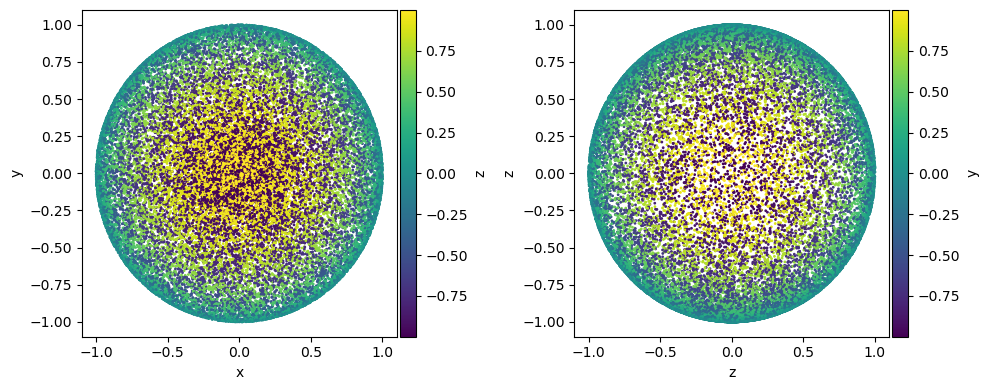

In [5]:
all_cart = RectangularCoords.all()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

s1 = axes[0].scatter(all_cart[:, 0], all_cart[:, 1], s=1, c=all_cart[:, 2])
s2 = axes[1].scatter(all_cart[:, 0], all_cart[:, 2], s=1, c=all_cart[:, 1])

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad="1%")
fig.colorbar(s1, cax=cax, label="z")

divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad="1%")
fig.colorbar(s2, cax=cax, label="y")

axes[0].set_ylabel("y")
axes[0].set_xlabel("x")
axes[1].set_ylabel("z")
axes[1].set_xlabel("x")
axes[1].set_xlabel("z")

plt.tight_layout()

# Why it matters?

Because selections around poles are very dificult to execute if you need to do math. The basic reason is that for each point you need to perform a distance on a sphere calculation between two points. While there is an explicit expression for a geodesic on a sphere it's quite expensive and numerically unstable for small distances, see [wiki](https://en.wikipedia.org/wiki/Great-circle_distance#Formulae)

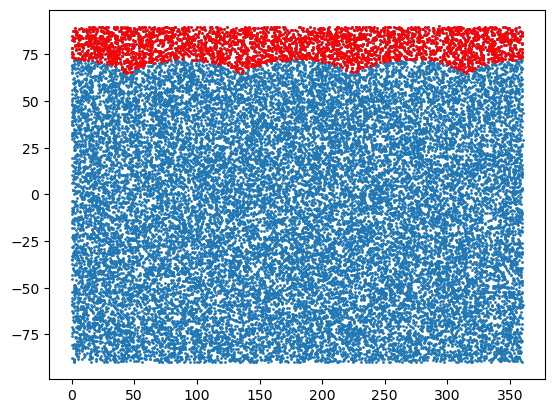

In [6]:
pole_cart = RectangularCoords.query_square(360, 90, 35)
plt.scatter(all_pointings[:, 0], all_pointings[:, 1], s=1)
plt.scatter(pole_cart[:, 0], pole_cart[:, 1], s=1, color="red")

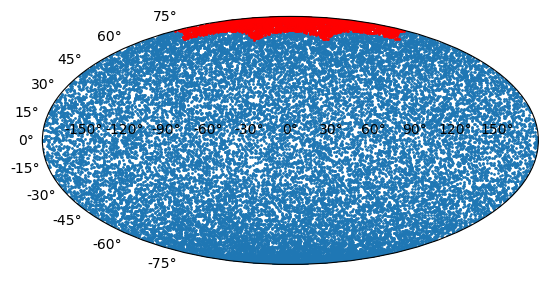

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="mollweide")

ra_center = Angle(all_pointings[:, 0], u.degree)
dec_center = Angle(all_pointings[:, 1], u.degree)
ra_center = ra_center.wrap_at(180*u.degree)

ra_square = Angle(pole_cart[:, 0], u.degree)
dec_square = Angle(pole_cart[:, 1], u.degree)
ra_square = ra_square.wrap_at(180*u.degree)

ax.scatter(ra_center.radian, dec_center.radian, s=1)
ax.scatter(ra_square.radian, dec_square.radian, s=1, color="red")

# In Heliocentric coordinates

To be able to transform the pointings above into heliocentric coordinate system position at a given distance we need to fully specify our WCS. Alongside specifying the reference pixel coordinates in image space and on the sky, and specifying the affine transformation between pixel coordinates and the on-sky coordinates, to fully contextualize the WCS we still need to specify the remaining missing WCS values - coordinate system, scale and time.

The reference pixel can then be transformed to heliocentric ecliptic coordinatey system and then expressed in its euclidean (rectangular) representation. From this point onwards - the mechanism of selecting overlapping exposures is the same as demonstrated above. Corner pixels are not recorded and transformed here as this is just an example and not a full implementation. 

There is a hiccup - the transformation path from central pixel to heliocentric space. To demnostrate the issue let's imagine that the observation was made on `2023-01-01T00:00:00.0000` and our WCS, as described above, specifies that the reference pixel has coordinates `(ra, dec)=(10.0, 10.0)` in `degrees` expressed in the `ICRS` coordinate system. Specifically `ICRS` because it is very similar, within 10s of miliarcseconds, to `J2000` equatorial coordinates.     
This is not the case for evey data product, historically, any of the `FK4`, `FK5` and `ICRS` coordinate systems were used.

We could just assume that because of `ICRS`'s simmilarity to `J2000` equatorial coordinate system the coordinates returned by WCS are already reasonable approximations to what we would observe from Earth, despite the fact `ICRS` is not geocentric. The transformation would then look like:

In [8]:
t = Time(59945.0, format="mjd", scale="utc")
ra = 10*u.deg
dec = 10*u.deg
distance = 50*u.AU

In [9]:
ICRS(
    ra=ra,
    dec=dec,
    distance=distance
).transform_to(HeliocentricTrueEcliptic(
    obstime=t
))

<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=59945.0): (lon, lat, distance) in (deg, deg, AU)
    (13.1094433, 5.23695941, 50.00874076)>

I believe this is incorrect. The transformation path is confusing, because the lie happens already in the first ICRS assignment of coordinates by the WCS. Those coordinates already represent what the object is projected as, not where it is. 

The specified distance is given in the ICRS frame and is approximately the same as the heliocentric distance, not the geocentric distance. But our observations of Solar System objects implicitly carry the geocentric distance, due to the parallax of transforming between geocentric and heliocentric system. This is dificult to demonstrate by a direct transformation to `HeliocentricTrueEcliptic`, because it requires the specification of distance in advance, so I'll demonstrate on `GeocentricTrueEcliptic`.

In [10]:
# without specifying distance a-priori, assumes, implicitly, the distance to Earth 
# at the time of observation instead
ICRS(
    ra=ra,
    dec=dec,
).transform_to(GeocentricTrueEcliptic(
    obstime=t
))

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=59945.0): (lon, lat, distance) in (deg, deg, )
    (13.11222353, 5.23864674, 1.)>

In [11]:
# while, once specified, because the distance is taken to be the distance from ICRS
# zero-point (~heliocentric distance) the parallax offsets the observed values in Geocentric
ICRS(
    ra=ra,
    dec=dec,
    distance=distance,
).transform_to(GeocentricTrueEcliptic(
    obstime=t
))

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=59945.0): (lon, lat, distance) in (deg, deg, AU)
    (11.97891514, 5.24217053, 49.96472122)>

This same principle works the other way, i.e. `GeocentricTrueEcliptic --> ICRS`, i.e. the WCS is already lying about the location of our object. The WCS is lying because at a given **finite** distance to the object, the parallax plays a large role in determining where would the object be projected if observed in ICRS coordinates from ICRS zero-point. And this is precisely what we're after.(?)

So we have to un-lie the WCS lies. I think this is the way to do it:

* First we go to `GeocentricTrueEcliptic`using the implicit distance from `ICRS` zero-point to Earth at a given time-stamp to correct for the parallax. I.e. we effectively recover the observation coordinates as they would be measured from Earth at the time of observation. We record the longitude and latitute of our object (reference pixel in this case)
* Secondly, we take the recovered longitude and latitude and set a new guess distance. Note that this is the geocentric distance to the observed object.
* Finally, only now do we transform to `HeliocentricTrueEcliptic` system again. 

This is the transformation that is occuring for each reference pixel of each faked WCS in our DB.        
The hard bit to get right there, with precission is the distance to object from geocentric system, which is `target_helio_dist - (pos_sun-posearth)`. I'll assume `guess_dist` ~ `geo_dist` but the difference is approximately ~0.8AU for example above.

In [12]:
# Step 0. Get reference pixel/object coordinates in ICRS
refpix_icrs = ICRS(ra=ra, dec=dec)

# Step 1. - recover coords as observed from Earth at the time of observing
refpix_geo = refpix_icrs.transform_to(GeocentricTrueEcliptic(obstime=t))

# Step 2 - observed objects are put at a guess geocentric distance calculated from target heliocentric distance
refpix_nolie = GeocentricTrueEcliptic(
    refpix_geo.lon,
    refpix_geo.lat,
    distance=distance,
    obstime=t
)

# Step 3. These are then finally transformed to the heliocentric system
refpix_nolie.transform_to(HeliocentricTrueEcliptic(obstime=t))

<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=59945.0): (lon, lat, distance) in (deg, deg, AU)
    (14.24038808, 5.23141759, 50.06333944)>

Note how the resulting coordinates do not match `ICRS --> HeliocentricTrueEcliptic` transformation above (near the `Heliocentric ...` title).

Text(0.5, 1.0, 'RaDec reference pixel coordinates')

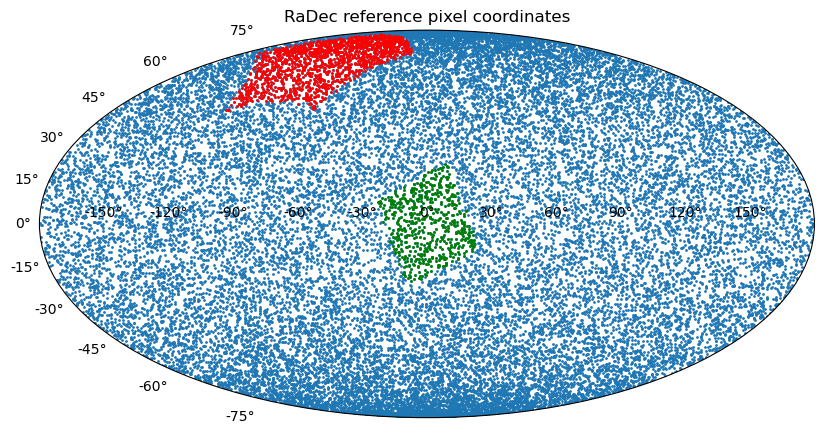

In [35]:
pole_cart = RectangularHeliocentricCoords.query_square(0, 90, 35)
pode_cart = RectangularHeliocentricCoords.query_square(0, 0, 35)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection="mollweide")

ra_center = Angle(all_pointings[:, 0], u.degree)
dec_center = Angle(all_pointings[:, 1], u.degree)
ra_center = ra_center.wrap_at(180*u.degree)

ra_square1 = Angle(pole_cart[:, 0], u.degree)
dec_square1 = Angle(pole_cart[:, 1], u.degree)
ra_square1 = ra_square.wrap_at(180*u.degree)

ra_square2 = Angle(pode_cart[:, 0], u.degree)
dec_square2 = Angle(pode_cart[:, 1], u.degree)
ra_square2 = ra_square2.wrap_at(180*u.degree)

ax.scatter(ra_center.radian, dec_center.radian, s=1)
ax.scatter(ra_square1.radian, dec_square1.radian, s=1, color="red")
ax.scatter(ra_square2.radian, dec_square2.radian, s=1, color="green")

ax.set_title("RaDec reference pixel coordinates")

## How do I know this is correct?

good question....

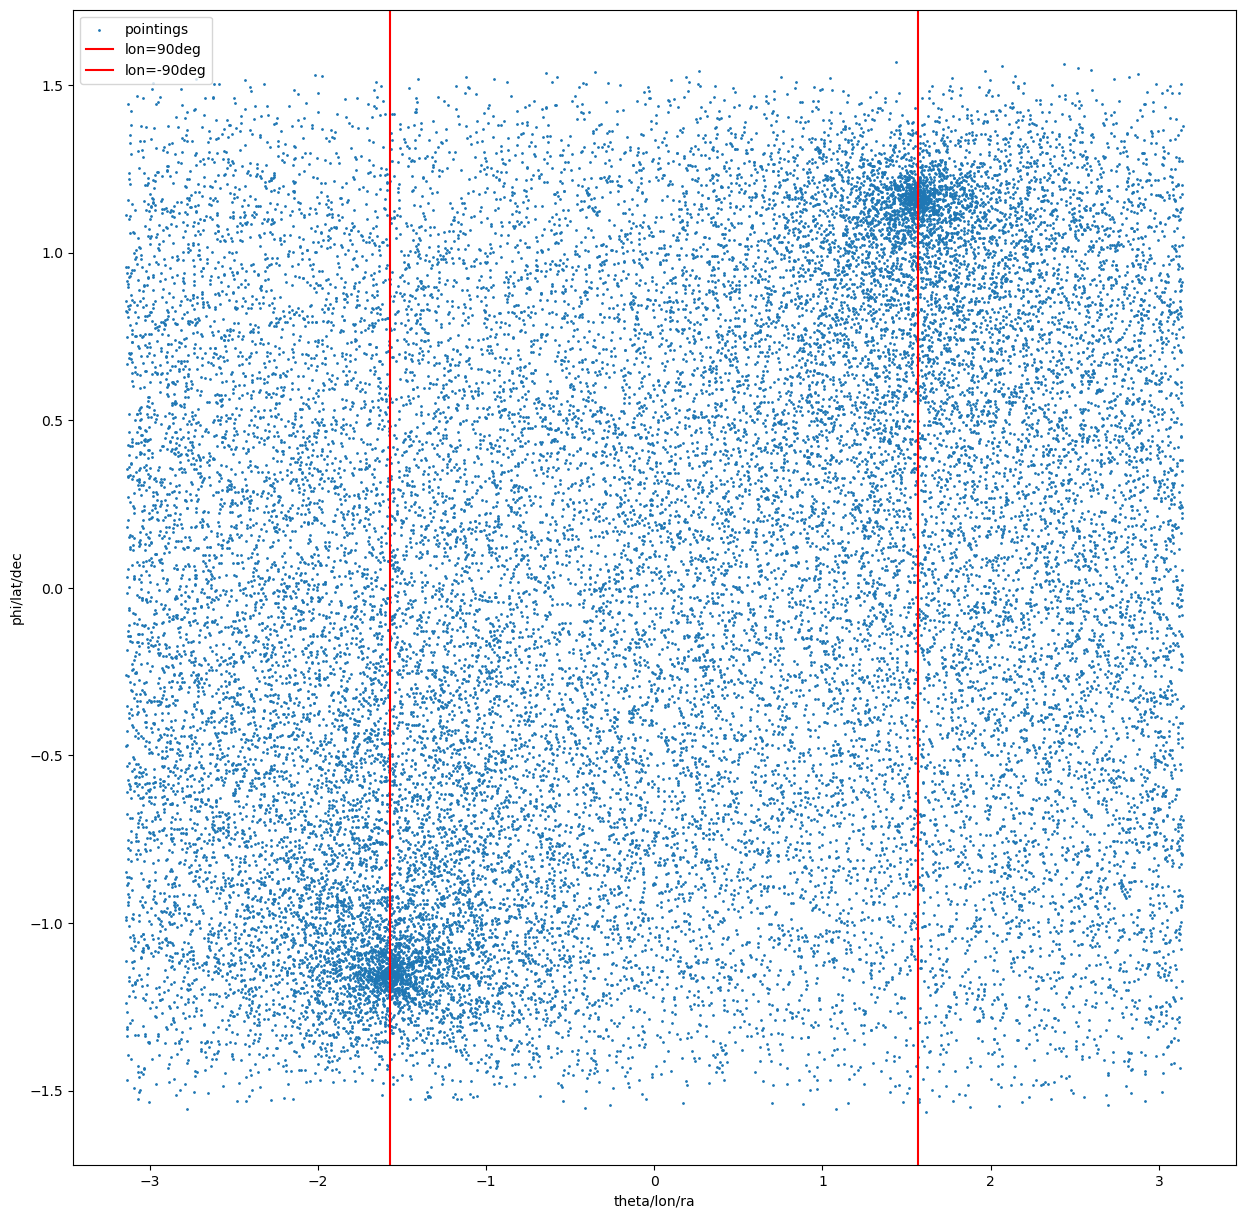

In [33]:
# all faked pointings
all_helio = RectangularHeliocentricCoords.all()
fig = plt.figure(figsize=(15, 15))
plt.scatter(test1.theta, test1.phi, s=1, label="pointings")
plt.axvline(np.pi/2, color="red", label="lon=90deg")
plt.axvline(-np.pi/2, color="red", label="lon=-90deg")
plt.xlabel("theta/lon/ra")
plt.ylabel("phi/lat/dec")
plt.legend()


Text(0, 0.5, 'dec')

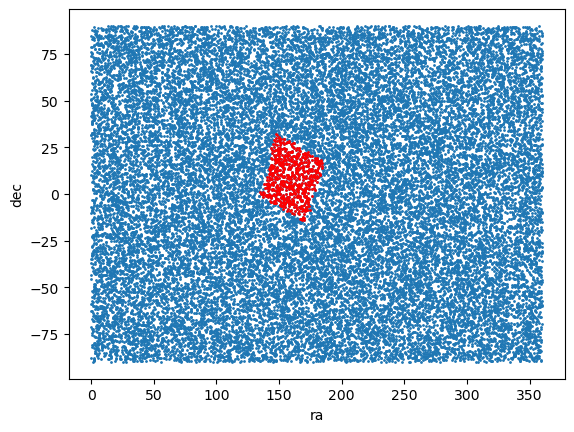

In [34]:
pole_cart = RectangularHeliocentricCoords.query_square(160, 0, 35)

plt.scatter(all_pointings[:, 0], all_pointings[:, 1], s=1)
plt.scatter(pole_cart[:, 0], pole_cart[:, 1], s=1, color="red")
plt.xlabel("ra")
plt.ylabel("dec")